# Imports

In [10]:
import requests
from bs4 import BeautifulSoup

from collections import defaultdict
import json
import re

import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

import time

import numpy as np

from pathlib import Path
import os

# Load statics

In [11]:
# Load stored course-site HTMLs
with open('valid_courses.json') as f:
    valid_courses = json.load(f)

# Load department color mapping
with open('department_colors.json') as f:
    department_colors = json.load(f)

# Load department names
with open('department_names.json') as f:
    department_names = json.load(f)

# Create graph

## Add nodes

The graph for the project consist of the data from DTU's webpage: https://kurser.dtu.dk/.

The initial attributes of the graph are:

* **course_num**: Course number
* **page**: HTML page
* **department**: Number of DTU department for the course
* **department_colors**: Colour of the corresponding department
* **department_names**: Name of DTU department for the course


In [12]:
# Initialize directd graph
G = nx.DiGraph()

# Go through each course
for course_num in valid_courses:
    department = course_num[:2] 
    G.add_node(course_num,
               course_num=course_num,
               page=valid_courses[course_num],
               department=department, 
               color=department_colors[department],
               department_name=department_names[department])

## Add edges

Edges are directed and are defined by the prerequisites 

In [13]:
for course_num in valid_courses:

    # Initialize BeautifulSoup object
    page = G.nodes[course_num]['page']
    soup = BeautifulSoup(page, 'html.parser')

    # Define the search pattern to match both "Academic prerequisites" and "Mandatory prerequisites"
    search_pattern = r"(Academic prerequisites|Mandatory Prerequisites)"
    
    # Find the label element that matches the pattern
    label = soup.find('label', string=re.compile(search_pattern))
    if label is None:
        continue  # Skip if no label is found
    
    # Get the parent element that contains the label and prerequisites
    parent = label.find_parent().find_parent()
    
    # Get the second <td> (assuming it contains the prerequisites text)
    prerequisite = parent.find_all('td')[1].text

    # Remove whitespace and line breaks
    prerequisite = prerequisite.replace('\r', ' ').replace('\n', ' ')

    # Extract 5-digit course numbers
    prerequisites = set(re.findall(r'\d{5}', prerequisite))
    
    # Add edges to the graph for valid prerequisites
    for prerequisite in prerequisites:
        if prerequisite in G.nodes:
            if prerequisite != course_num:  # Skip self-loops
                G.add_edge(prerequisite, course_num)


## Add text attributes

Attributes are added:

* **course_title**: Title of the course
* **course_text**: Cleaned text of the description from webpage
* **text_size**: Number of characters in the description
* **word_count**: Number of words in the description


In [14]:
id_to_name = {}
for node in G.nodes:
    
    ### Initialize BeuatifulSoup object
    page = G.nodes[node]['page']
    soup = BeautifulSoup(page, 'html.parser')
    
    ### Add title to node
    title = soup.title.text
    cleaned = ' '.join(title.strip().split())[6:]
    G.nodes[node]['course_title'] = cleaned
    id_to_name[node] = cleaned
    
    ### Add course text to node (General course objectives + Learning objectives + Content)
    div = soup.find('div', string=re.compile("General course objectives")).parent(string=True)
    
    remove_indeces = []
    for d, text in enumerate(div):
        if text in ["General course objectives", "Learning objectives", "Content", "Last updated", "\r\nA student who has met the objectives of the course will be able to:\r\n\r\n"]:
            remove_indeces.append(d)
    
    new_div = [div[i] for i in range(len(div)) if i not in remove_indeces]
    text = ' '.join(new_div[:-1]).replace('\r', ' ').replace('\n', '')
    cleaned = ' '.join(text.strip().split())
    G.nodes[node]['course_text'] = cleaned  
    G.nodes[node]['text_size'] = len(cleaned) 
    G.nodes[node]['word_count'] = len(cleaned.split())

    
# delete ../graphs.json
file_path = Path("../id_to_name.json")
if file_path.exists():
    os.remove(file_path)
    print(f"Deleted {file_path}")
    
with open('../id_to_name.json', 'w') as f:
    json.dump(id_to_name, f, indent=4)

Deleted ../id_to_name.json


# Course dependencies overview

In [15]:

def graph_to_json(center_node, G, levels, filename="../graphs.json"):
    
    # get maximum number of nodes that are at the same level. One for level<0 and one for level>0
    subseq_height = defaultdict(int)
    prereq_height = defaultdict(int)

    for level in levels.values():
        if level > 0:
            subseq_height[level] += 1
        elif level < 0:
            prereq_height[abs(level)] += 1

    # Convert graph to the desired dict format
    graph_data = {
        "nodes": [{"id": str(n), "level": levels.get(n, 0)} for n in G.nodes()],
        "edges": [{"source": str(u), "target": str(v)} for u, v in G.edges()],
        "max_subseq": max(levels.values(), default=0),
        "max_prereq": abs(min(levels.values(), default=0)),
        "subseq_height": max(subseq_height.values(), default=0),
        "prereq_height": max(prereq_height.values(), default=0)
    }
    
    
    # Ensure file exists (with empty dict if not)
    file_path = Path(filename)
    if file_path.exists():
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
    else:
        data = {}
    
    # Add or overwrite this graph entry
    data[str(center_node)] = graph_data
    
    # Write back to file
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

# # Example usage:
# G = nx.Graph()
# G.add_node("01002", name="Math")
# G.add_node("01003")
# G.add_node("01567")
# G.add_edges_from([("01003", "01002"), ("01002", "01567")])
# graph_to_json("01002", G)


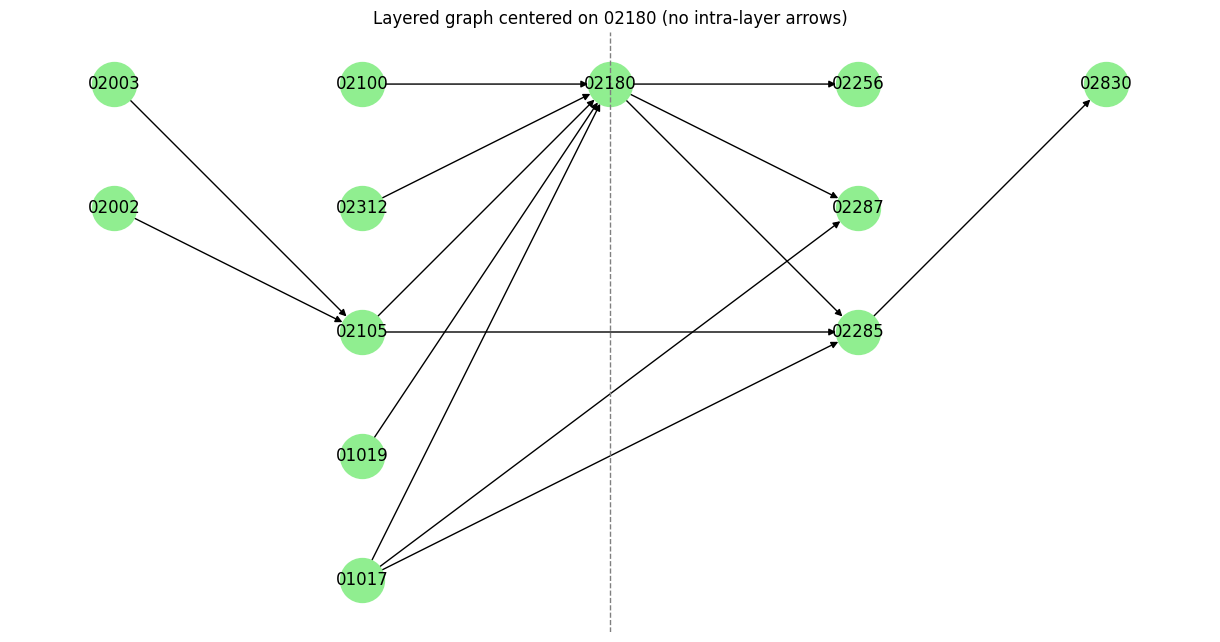

In [30]:
# delete ../graphs.json
# import os
# file_path = Path("../graphs.json")
# if file_path.exists():
#     os.remove(file_path)
#     print(f"Deleted {file_path}")
    
    

# Get all courses
all_course_nums = list(G.nodes())
center_node = '02180'#all_course_nums[26]

# for center_node in all_course_nums:

# Get forward and reverse BFS nodes
forward_nodes = nx.single_source_shortest_path_length(G, center_node)
reverse_nodes = nx.single_source_shortest_path_length(G.reverse(copy=False), center_node)

# Combine all relevant nodes
all_nodes = set(forward_nodes.keys()) | set(reverse_nodes.keys())
levels = {}

for node in all_nodes:
    if node == center_node:
        levels[node] = 0
    elif node in reverse_nodes:
        levels[node] = -reverse_nodes[node]
    else:
        levels[node] = forward_nodes[node]

# Filter edges: only include edges between different levels
# edges = [
#     (u, v) for u, v in G.subgraph(all_nodes).edges()
#     if levels[u] != levels[v]
# ]

    


# Create a new DiGraph with only those edges
filtered_subG = nx.DiGraph()
filtered_subG.add_nodes_from(all_nodes)


# Build layout positions
pos = {}
level_nodes = {}
for node, level in levels.items():
    level_nodes.setdefault(level, []).append(node)

for level in sorted(level_nodes):
    nodes = level_nodes[level]
    for i, node in enumerate(nodes):
        pos[node] = (level, -i)

edges = [
    (u, v) for u, v in G.subgraph(all_nodes).edges()
    if pos[u][0] < pos[v][0]
]
filtered_subG.add_edges_from(edges)

# Write to JSON
# graph_to_json(center_node, filtered_subG, levels)

# Plot
plt.figure(figsize=(12, 6))
nx.draw(filtered_subG, pos, with_labels=True, node_color="lightgreen", node_size=1000, arrows=True)
plt.title(f"Layered graph centered on {center_node} (no intra-layer arrows)")
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.show()


https://stackoverflow.com/questions/20037122/draw-an-arrow-between-two-divs